In [13]:
%load_ext autoreload
%autoreload 2
import sys 
from FR3Py.robot.interface import FR3Real
robot = FR3Real(robot_id='fr3')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Interface Running...


In [14]:
robot.getJointStates()

{'q': array([ 9.65381890e-04, -7.83867252e-01,  3.17366616e-03, -2.36699849e+00,
        -7.33907766e-04,  1.57122138e+00,  7.85987105e-01]),
 'dq': array([ 0.00160673,  0.00044602,  0.00147811,  0.0012091 ,  0.00062231,
        -0.00039501,  0.00062915]),
 'T': array([-0.21097112, -4.22265768, -0.90254819, 23.07193375,  1.01732099,
         2.04160285, -0.04346249])}

### Preparation

In [15]:
import numpy as np
from FR3Py.robot.model_collision_avoidance import PinocchioModel
import time

pin_robot = PinocchioModel()
joint_lb = np.array([-2.3093, -1.5133, -2.4937, -2.7478, -2.48, 0.8521, -2.6895])
joint_ub = np.array([2.3093, 1.5133, 2.4937, -0.4461, 2.48, 4.2094, 2.6895])
torque_lb = np.array([-87, -87, -87, -87, -12, -12, -12])
torque_ub = np.array([87, 87, 87, 87, 12, 12, 12])
joint_acc_lb = np.array([-10, -10, -10, -10, -10, -10, -10])
joint_acc_ub = np.array([10, 10, 10, 10, 10, 10, 10])

n_joints = 7
q_bar = 0.5*(joint_ub + joint_lb)


In [16]:
from cores.utils.bounding_shape_coef_mj import BoundingShapeCoef
from cores.obstacle_collections.polytope_collection import PolytopeCollection
import scalingFunctionsHelperPy as sfh
import HOCBFHelperPy as hh
from scipy.spatial.transform import Rotation
import multiprocessing
from cores.utils.trajectory_utils import PositionTrapezoidalTrajectory, OrientationTrapezoidalTrajectory
from liegroups import SO3
from cores.utils.proxsuite_utils import init_proxsuite_qp
from cores.utils.rotation_utils import get_quat_from_rot_matrix

In [17]:
# Obstacle parameters
obstacle_config = {
    "obs1":{
        "type": "polytope3d",
        "vertices": [[0.226, 0.293, 0.28], [0.234, 0.287, 0.28], [0.416, 0.543, 0.28], [0.424, 0.537, 0.28], [0.226, 0.293, 0.0], [0.234, 0.287, 0.0], [0.416, 0.543, 0.0], [0.424, 0.537, 0.0]],
        "pos": [0.0, 0.0, 0.0],
        "quat": [0.0, 0.0, 0.0, 1.0]
    },

    "obs2":{
        "type": "polytope3d",
        "vertices": [[0.417, 0.536, 0.28], [0.423, 0.544, 0.28], [0.047, 0.826, 0.28], [0.053, 0.834, 0.28], [0.417, 0.536, 0.0], [0.423, 0.544, 0.0], [0.047, 0.826, 0.0], [0.053, 0.834, 0.0]],
        "pos": [0.0, 0.0, 0.0],
        "quat": [0.0, 0.0, 0.0, 1.0]
    },

    "obs3":{
        "type": "polytope3d",
        "vertices": [[0.054, 0.827, 0.28], [0.046, 0.833, 0.28], [-0.136, 0.577, 0.28], [-0.144, 0.583, 0.28], [0.054, 0.827, 0.0], [0.046, 0.833, 0.0], [-0.136, 0.577, 0.0], [-0.144, 0.583, 0.0]],
        "pos": [0.0, 0.0, 0.0],
        "quat": [0.0, 0.0, 0.0, 1.0]
    },

    "obs4":{
        "type": "polytope3d",
        "vertices": [[-0.137, 0.584, 0.28], [-0.143, 0.576, 0.28], [0.233, 0.294, 0.28], [0.227, 0.286, 0.28], [-0.137, 0.584, 0.0], [-0.143, 0.576, 0.0], [0.233, 0.294, 0.0], [0.227, 0.286, 0.0]],
        "pos": [0.0, 0.0, 0.0],
        "quat": [0.0, 0.0, 0.0, 1.0]
    }

}

In [18]:
# Load the bounding shape coefficients
BB_coefs = BoundingShapeCoef()
# selected_BBs = ["HAND_BB", "LINK7_BB", "LINK6_BB"]
selected_BBs = ["HAND_BB"]
n_selected_BBs = len(selected_BBs)

# Obstacle
n_obstacle = len(obstacle_config)
obs_col = PolytopeCollection(3, n_obstacle, obstacle_config)

# CBF parameters
alpha0 = 1.03
gamma1 = 20
gamma2 = 20
compensation = 0
obstacle_kappa = 80

# Create the problem collection
n_threads = max(multiprocessing.cpu_count() -1, 1)
probs = hh.Problem3dCollection(n_threads)
for (i, bb_key) in enumerate(selected_BBs):
    for (j, obs_key) in enumerate(obs_col.face_equations.keys()):
        frame_id = i

        ellipsoid_quadratic_coef = BB_coefs.coefs[bb_key]
        SF_rob = sfh.Ellipsoid3d(True, ellipsoid_quadratic_coef, np.zeros(3))

        A_obs_np = obs_col.face_equations[obs_key]["A"]
        b_obs_np = obs_col.face_equations[obs_key]["b"]
        obs_kappa = obstacle_kappa
        vertices = obs_col.face_equations[obs_key]["vertices_in_world"]
        SF_obs = sfh.LogSumExp3d(False, A_obs_np, b_obs_np, obs_kappa)

        prob = hh.ElliposoidAndLogSumExp3dPrb(SF_rob, SF_obs, vertices)

        probs.addProblem(prob, frame_id)

# Define proxuite problem
n_CBF = n_selected_BBs*n_obstacle
n_controls = 7
cbf_qp = init_proxsuite_qp(n_v=n_controls, n_eq=0, n_in=n_controls+n_CBF)

/workspaces/HOCBF-FR3-Experiments/cores/obstacle_collections/polytope_collection.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='single')


In [35]:
# Rotate link 1 to reach preparation configuration
T = 10
q_d = np.array([np.pi/3, -np.pi/4, 0, -np.pi/4*3, 0, np.pi/2, np.pi/4])
Kp_joint = np.diag([1, 1, 1, 1, 1, 1, 1])*1e2
Kd_joint = np.diag([2, 2, 2, 2, 2, 2, 2])*1e2
t_start = time.time()
while time.time() - t_start < T:
    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)

    q_pin = 0.025*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    M = pin_info["M"][0:n_joints,0:n_joints] + 0.1*np.eye(n_joints) # shape (7,7)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)

    W = np.diag(1.0/(joint_ub-joint_lb))
    eq = W @ (q - q_d)
    deq = W @ dq
    u = M @ (- Kd_joint @ deq - Kp_joint @ eq)
    u = np.clip(u, torque_lb, torque_ub)
    robot.setCommands(u)

robot.setCommands(np.zeros_like(u))


In [36]:
t_final = 30
t_1 = 10
t_2 = 20

# Translational trajectory
P_EE_0 = P_EE.copy()
# P_EE_1 = np.array([0.16, 0.62, 0.04])
P_EE_1 = np.array([0.18, 0.61, 0.04])
P_EE_2 = np.array([0.45, 0.25, 0.01])

via_points = np.array([P_EE_0, P_EE_1, P_EE_2, P_EE_2])
target_time = np.array([0, t_1, t_2, t_final])
Ts = 0.01
traj_position = PositionTrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=Ts)

# Rotational trajectory
# roll = np.pi
# pitch = 0
# yaw = np.pi/3
# R_EE_0 = Rotation.from_euler('xyz', [roll, pitch, yaw]).as_matrix()
R_EE_0  = R_EE.copy()

roll = np.pi
pitch = 0
yaw = np.pi/3
R_EE_1 = Rotation.from_euler('xyz', [roll, pitch, yaw]).as_matrix()

roll = np.pi
pitch = 0
yaw = np.pi/6
R_EE_2 = Rotation.from_euler('xyz', [roll, pitch, yaw]).as_matrix()

orientations = np.array([R_EE_0, R_EE_1, R_EE_2, R_EE_2])
target_time = np.array([0, t_1, t_2, t_final])
traj_orientation = OrientationTrapezoidalTrajectory(orientations, target_time, Ts=Ts)

### Collision avoidance

In [37]:
T = 10
# K_p_pos = np.diag([100,100,100])*0.5
# K_d_pos = np.diag([50,50,50])*0.1

K_p_pos = np.diag([100,100,100])*0.0
K_d_pos = np.diag([50,50,50])*0.0

K_p_rot = np.diag([200,200,200])*0.5
K_d_rot = np.diag([100,100,100])*0.2

Kp_joint = 20*np.diag([1, 1, 1, 1, 1, 1, 1])
Kd_joint = 10*np.diag([1, 1, 1, 1, 1, 1, 1])

qdtdt_list = []
tau_list = []
all_h_list = []

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    traj_pos, traj_pos_dt, traj_pos_dtdt = traj_position.get_traj_and_ders(t)
    traj_ori, traj_ori_dt, traj_ori_dtdt = traj_orientation.get_traj_and_ders(t)

    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)

    q_pin = 0.025*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)

    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + 0.1*np.eye(n_joints) # shape (7,7)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)

    # Primary obejctive: tracking control
    e_pos = P_EE - traj_pos # shape (3,)
    e_pos_dt = v_EE[:3] - traj_pos_dt # shape (3,)
    v_dt = traj_pos_dtdt - K_p_pos @ e_pos - K_d_pos @ e_pos_dt

    e_rot = SO3(R_EE @ traj_ori.T).log() # shape (3,)
    e_rot_dt = v_EE[3:] - traj_ori_dt # shape (3,)
    omega_dt = traj_ori_dtdt -K_p_rot @ e_rot - K_d_rot @ e_rot_dt

    v_EE_dt_desired = np.concatenate([v_dt, omega_dt])
    S = J_EE
    S_pinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    S_null = (np.eye(len(q)) - S_pinv @ S)
    q_dtdt_task = S_pinv @ (v_EE_dt_desired - dJdq_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    q_bar = 1/2*(joint_ub+joint_lb)
    e_joint = W @ (q - q_bar)
    e_joint_dot = W @ dq
    q_dtdt_nominal = q_dtdt_task + S_null @ (- Kp_joint @ e_joint - Kd_joint @ e_joint_dot)

    # CBF
    u_nominal = q_dtdt_nominal

    # C = np.zeros([n_controls+n_CBF, n_controls])
    # lb = np.zeros(n_controls+n_CBF)
    # ub = np.zeros(n_controls+n_CBF)
    # CBF_tmp = np.zeros(n_CBF)
    # phi1_tmp = np.zeros(n_CBF)
    # phi2_tmp = np.zeros(n_CBF)

    all_P_np = np.zeros([n_selected_BBs, 3])
    all_quat_np = np.zeros([n_selected_BBs, 4])
    all_J_np = np.zeros([n_selected_BBs, 6, 7])
    all_dJdq_np = np.zeros([n_selected_BBs, 6])

    for (ii, bb_key) in enumerate(selected_BBs):
        all_P_np[ii, :] = pin_info["P_"+bb_key]
        all_J_np[ii, :, :] = pin_info["J_"+bb_key][:,:7]
        all_quat_np[ii, :] = get_quat_from_rot_matrix(pin_info["R_"+bb_key])
        all_dJdq_np[ii, :] = pin_info["dJdq_"+bb_key][:7]

    all_h_np, _, _, all_phi1_np, all_actuation_np, all_lb_np, all_ub_np = \
        probs.getCBFConstraints(dq, all_P_np, all_quat_np, all_J_np, all_dJdq_np, alpha0, gamma1, gamma2, compensation)
    
    # C[0:n_CBF,:] = all_actuation_np
    # lb[0:n_CBF] = all_lb_np
    # ub[0:n_CBF] = all_ub_np
    # CBF_tmp = all_h_np
    # phi1_tmp = all_phi1_np

    # # CBF-QP constraints
    # # print(np.min(CBF_tmp))
    # g = -u_nominal

    # C[n_CBF:n_CBF+n_controls,:] = np.eye(n_controls)
    # lb[n_CBF:n_CBF+n_controls] = joint_acc_lb[:7]
    # ub[n_CBF:n_CBF+n_controls] = joint_acc_ub[:7]

    # cbf_qp.update(g=g, C=C, l=lb, u=ub)
    # cbf_qp.solve()
    # u = cbf_qp.results.x
    # tau = M @ u +  nle - G

    # tau = M @ u_nominal +  nle - G
    tau = M @ u_nominal

    tau = np.clip(tau, -20, 20)
    robot.setCommands(tau)

    qdtdt_list.append(u_nominal.copy())
    tau_list.append(tau.copy())
    all_h_list.append(all_h_np.copy())

robot.setCommands(np.zeros_like(tau))


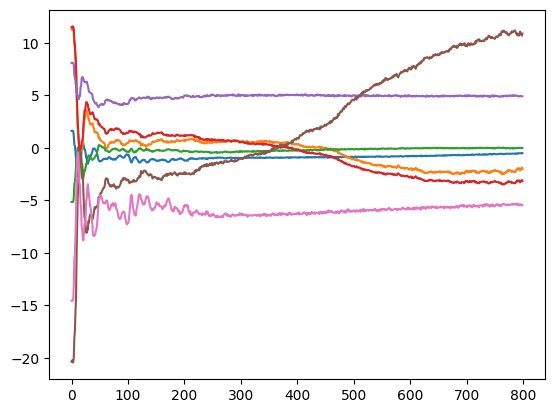

In [34]:
import matplotlib.pyplot as plt

qdtdt_list = np.array(qdtdt_list)

plt.figure()
plt.plot(qdtdt_list[:800,:])


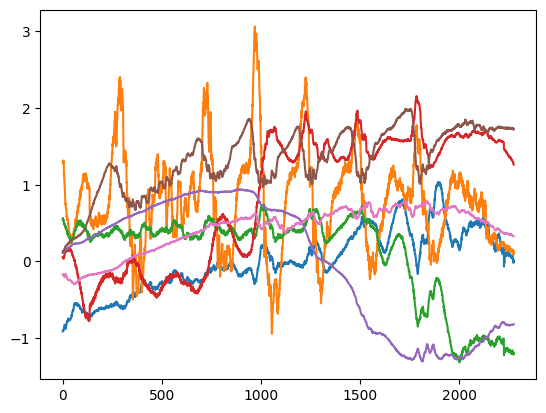

In [38]:
tau_list = np.array(tau_list)
plt.figure()
plt.plot(tau_list)

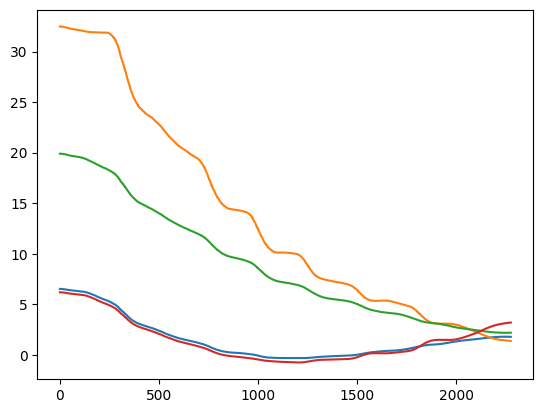

In [39]:
all_h_list = np.array(all_h_list)
plt.figure()
plt.plot(all_h_list)

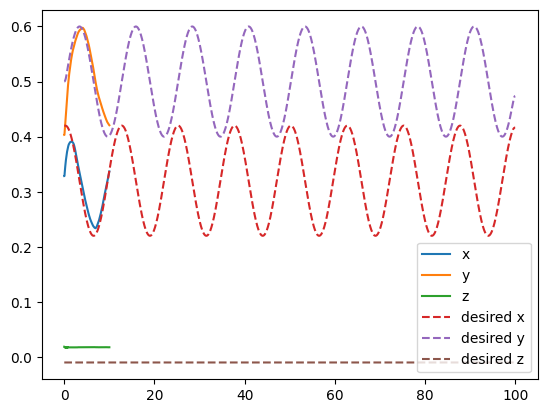

In [67]:
import matplotlib.pyplot as plt

pos_list = np.array(pos_list)
u_nominal_list = np.array(u_nominal_list)
t_list = np.array(t_list)

plt.figure()
plt.plot(t_list, pos_list[:,0], label='x')
plt.plot(t_list, pos_list[:,1], label='y')
plt.plot(t_list, pos_list[:,2], label='z')
plt.plot(traj.t, traj.pd[:,0], '--', label='desired x')
plt.plot(traj.t, traj.pd[:,1], '--', label='desired y')
plt.plot(traj.t, traj.pd[:,2], '--', label='desired z')
plt.legend()



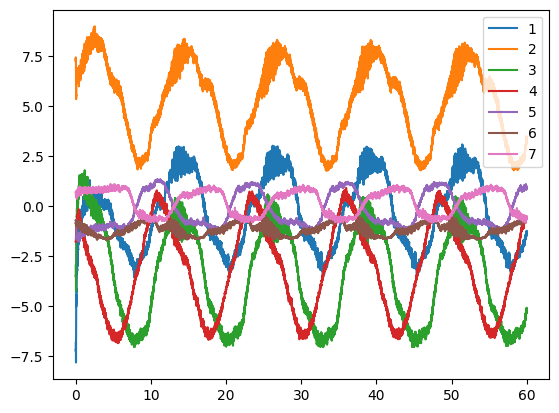

In [10]:

plt.figure()
plt.plot(t_list, u_nominal_list[:,0], label='1')
plt.plot(t_list, u_nominal_list[:,1], label='2')
plt.plot(t_list, u_nominal_list[:,2], label='3')
plt.plot(t_list, u_nominal_list[:,3], label='4')
plt.plot(t_list, u_nominal_list[:,4], label='5')
plt.plot(t_list, u_nominal_list[:,5], label='6')
plt.plot(t_list, u_nominal_list[:,6], label='7')

plt.legend()


### Recover to initial pose

In [55]:
via_points = np.array([P_EE, np.array([P_EE[0], P_EE[1], P_EE[2]+0.2])])
target_time = np.array([0, 5])
traj = TrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=0.01)

In [56]:
T = 7

Kp_task = np.diag([40,40,40,100,100,100])
Kd_task = np.diag([40,40,40,100,100,100])

Kp_joint = np.diag([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])*10
Kd_joint = np.diag([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])*10

delta = 0.1

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    traj_pos, traj_vel, traj_acc = traj.get_traj_and_ders(t)

    q = 0.025*np.ones(9)
    dq = np.zeros(9)
    robot_info = robot.getStates()
    q[0:n_joints] = robot_info['q']
    dq[0:n_joints] = robot_info['dq']

    pin_info = pin_robot.getInfo(q, dq)
    q = q[0:n_joints]
    dq = dq[0:n_joints]
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + delta*np.eye(n_joints) # shape (7,7)
    # Minv = pin_info["Minv"][0:n_joints,0:n_joints]   # shape (7,7)
    Minv = np.linalg.inv(M)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)

    S, u_task = get_torque_to_track_traj_const_ori(traj_pos, traj_vel, traj_acc, R_EE_desired, Kp_task, Kd_task, Minv, J_EE, dJdq_EE, dq, P_EE, R_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    eq = W @ (q - q_bar)
    deq = W @ dq
    u_joint = M @ (- Kd_joint @ deq - Kp_joint @ eq) 

    # Compute the input torque
    Spinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    u_nominal =  Spinv @ u_task + (np.eye(len(q)) - Spinv @ S) @ u_joint
    u = np.clip(u_nominal, -20, 20)
    robot.setCommands(u)

robot.setCommands(np.zeros_like(u))

In [ ]:
while True:
    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)

    q_pin = 0.025*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)
    print(pin_info["P_EE"])